In [1]:
import sys
sys.path.append('../../..')
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import xarray as xr
import random as rd
import platform
import adamod

import torch
import torch.nn as nn
from datetime import datetime
from torch.utils.data import Dataset, DataLoader
from torch import optim
from utils.dataset import NCDFDatasets
from utils.trainer import Trainer
from utils.trainer import Tester
from convlstm import ConvLSTM

Load specific variables for each dataset

In [3]:
version = 1
data_path = '../../../data/dataset-chirps-1981-2019-seq5-ystep5.nc'
dataset_type = 'chirps'
param = {'layer_size': 3, 'kernel_size': 5, 'hidden_dim': 32}

In [4]:

#util = Util('STConvS2S', version=version, dataset_type=dataset_type)

os.environ["CUDA_VISIBLE_DEVICES"]='0'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda', index=0)

In [5]:
print(torch.version.cuda)

10.1


Seed

In [6]:
seed = 1000
np.random.seed(seed)
rd.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic=True

In [7]:
def init_seed(seed):
    np.random.seed(seed)

In [8]:
init_seed = init_seed(seed)

Hyperparameters

In [9]:
epochs = 50
batch_size = 25
validation_split = 0.2
dropout_rate = 0.8
test_split = 0.2
layer_size = param['layer_size']
kernel_size = param['kernel_size']
hidden_dim = param['hidden_dim']

Loading the dataset

In [10]:
dataset = xr.open_dataset(data_path)
dataset

<xarray.Dataset>
Dimensions:  (channel: 1, lat: 50, lon: 50, sample: 13960, time: 5)
Coordinates:
  * lat      (lat) int64 -39 -38 -37 -36 -35 -34 -33 -32 ... 3 4 5 6 7 8 9 10
  * lon      (lon) int64 -84 -83 -82 -81 -80 -79 -78 ... -40 -39 -38 -37 -36 -35
Dimensions without coordinates: channel, sample, time
Data variables:
    x        (sample, time, lat, lon, channel) float32 ...
    y        (sample, time, lat, lon, channel) float32 ...
Attributes:
    description:  The variables have preciptation values and are separable in...

In [11]:
data = NCDFDatasets(dataset, val_split = validation_split, test_split = test_split)
train_data = data.get_train()
val_data = data.get_val()
test_data = data.get_test()

In [12]:
print('[X_train] Shape:', train_data.x.shape)
print('[y_train] Shape:', train_data.y.shape)
print('[X_val] Shape:', val_data.x.shape)
print('[y_val] Shape:', val_data.y.shape)
print('[X_test] Shape:', test_data.x.shape)
print('[y_test] Shape:', test_data.y.shape)

[X_train] Shape: torch.Size([8376, 1, 5, 50, 50])
[y_train] Shape: torch.Size([8376, 1, 5, 50, 50])
[X_val] Shape: torch.Size([2792, 1, 5, 50, 50])
[y_val] Shape: torch.Size([2792, 1, 5, 50, 50])
[X_test] Shape: torch.Size([2792, 1, 5, 50, 50])
[y_test] Shape: torch.Size([2792, 1, 5, 50, 50])


In [13]:
params = {'batch_size': batch_size,
          'num_workers': 4, 
          'worker_init_fn': init_seed}

train_loader = DataLoader(dataset=train_data, shuffle=True, **params)
val_loader = DataLoader(dataset=val_data, shuffle=False, **params)
test_loader = DataLoader(dataset=test_data, shuffle=False, **params)

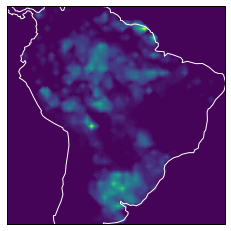

In [14]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy
#sample, ch, time, lat, lon
sst = train_data.y[0, 0, 0, :, :]
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]

ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(lons, lats, sst, 60,
             transform=ccrs.PlateCarree())
ax.coastlines(color='white')

plt.show()

Creating the model

In [15]:
class STConvLSTM(nn.Module):
    
    def __init__(self, layer_size, kernel_size, input_size, hidden_dim):
        super(STConvLSTM, self).__init__()
        
        self.conv_lstm_layer = nn.ModuleList()
        self.relu_layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()
        self.dropout_layers = torch.nn.ModuleList()
        
        input_dim=1
        for i in range(layer_size):
            self.conv_lstm_layer.append(ConvLSTM(input_size=input_size, input_dim=input_dim, hidden_dim=hidden_dim,
                                                kernel_size=(kernel_size, kernel_size),
                                                 num_layers=1, batch_first=True, bias=False, return_all_layers=True))
            self.relu_layers.append(nn.ReLU())
            self.bn_layers.append(nn.BatchNorm3d(hidden_dim))
            self.dropout_layers.append(nn.Dropout(dropout_rate))
            input_dim = hidden_dim
            
        self.final_conv = nn.Conv3d(in_channels=hidden_dim, out_channels=1, 
                                    kernel_size=(1,1,1), padding=0)
        
    def forward(self, x):
        for convlstm, relu, bn, drop in zip(self.conv_lstm_layer, self.relu_layers, self.bn_layers, self.dropout_layers):
            x, h = convlstm(x)
            x = bn(x[0])
            x = relu(x)
            x = drop(x)
            
        out = self.final_conv(x)
        return out

In [16]:
model = STConvLSTM(layer_size, kernel_size, input_size=(train_data.x.shape[3], train_data.x.shape[4]), hidden_dim=hidden_dim).to(device)
criterion = torch.nn.L1Loss()
opt_params = {'lr': 0.001, 
              'alpha': 0.9, 
              'eps': 1e-6}
optimizer = torch.optim.RMSprop(model.parameters(), **opt_params)

Training the model

In [17]:
model_path = os.path.join('../../../models/CHIRPS/1_step/ConvLSTM_MAE' + '_' + datetime.now().strftime('m%md%d-h%Hm%Ms%S') + '.pth.tar')
trainer = Trainer(model, train_loader, val_loader, criterion, optimizer, 100, device, True, model_path, False, 5)


In [18]:
train_losses, val_losses = trainer.train_evaluate()

Train - Epoch 0, Epoch Loss: 2.406730
Val Avg. Loss: 2.446366
=> Saving a new best
Train - Epoch 1, Epoch Loss: 2.384272
Val Avg. Loss: 2.450402
Train - Epoch 2, Epoch Loss: 2.384439
Val Avg. Loss: 2.416338
=> Saving a new best
Train - Epoch 3, Epoch Loss: 2.380392
Val Avg. Loss: 2.414089
=> Saving a new best
Train - Epoch 4, Epoch Loss: 2.374593
Val Avg. Loss: 2.407393
=> Saving a new best
Train - Epoch 5, Epoch Loss: 2.372669
Val Avg. Loss: 2.412239
Train - Epoch 6, Epoch Loss: 2.377039
Val Avg. Loss: 2.407495
Train - Epoch 7, Epoch Loss: 2.371710
Val Avg. Loss: 2.416551
Train - Epoch 8, Epoch Loss: 2.371520
Val Avg. Loss: 2.401650
=> Saving a new best
Train - Epoch 9, Epoch Loss: 2.371137
Val Avg. Loss: 2.408759
Train - Epoch 10, Epoch Loss: 2.372542
Val Avg. Loss: 2.406762
Train - Epoch 11, Epoch Loss: 2.365662
Val Avg. Loss: 2.401668
Train - Epoch 12, Epoch Loss: 2.369749
Val Avg. Loss: 2.404990
Train - Epoch 13, Epoch Loss: 2.365664
Val Avg. Loss: 2.405185


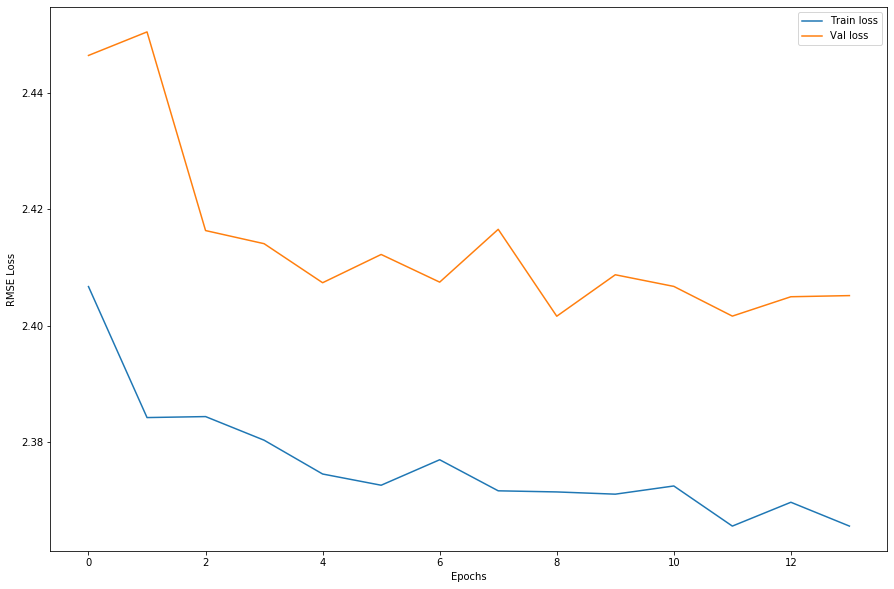

In [19]:
import matplotlib.pyplot as plt
epochs = np.arange(1,len(val_losses))
plt.figure(figsize=(15,10)) 
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['Train loss', 'Val loss'], loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("RMSE Loss")
plt.show()

Evaluating the model

In [20]:
model, optimizer, epoch, loss = trainer.load_model()
tester = Tester(model, test_loader, criterion, optimizer, device, True, False)
test_loss = tester.test()
loss_type = type(criterion).__name__
print(f'STConvS2S {loss_type}: {test_loss:.4f}')

STConvS2S L1Loss: 2.4065


In [ ]:
if (torch.cuda.is_available()):
    torch.cuda.empty_cache()